<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW2/HW2_file3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2. Deeper networks

* using ideas from https://arxiv.org/pdf/1409.1556.pdf

Simple networks with 5x5 conv2D layers (file 1) as well as with 3x3 conv2d layers (file 2) saturated at about 70% accuracy.

In this files, several networks with with more 3x3 conv2d layers and "missing" maxpooling layers were tested.

## Credits
* Data loading is based on cifar10_data_set.ipynb
* Several ideas were borrowed from https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/ 
* Several ideas were borrowed from https://arxiv.org/pdf/1409.1556.pdf

## Loading the CIFAR10 data set

In [2]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Using TensorFlow backend.


## Preparing the data

In [0]:
from keras.utils import to_categorical

orig_tr_y = to_categorical(train_labels)

test_y = to_categorical(test_labels)

orig_tr_x = train_images.astype('float32') / 255

test_x = test_images.astype('float32') / 255 

class_names = ['airplan', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Splitting original train set into smaller train and validate sets

In [0]:
import numpy as np
# we want to split "randomly" but reproducible
np.random.seed(1000)
m=len(orig_tr_x)
m_tr = int(m * 0.9) # will split 90:10
m_val = m - m_tr
shuffled_indices = np.random.permutation(m)
orig_tr_x_s = orig_tr_x[shuffled_indices]
orig_tr_y_s = orig_tr_y[shuffled_indices]
# splitting
tr_x = orig_tr_x_s[:m_tr]
tr_y = orig_tr_y_s[:m_tr]
val_x = orig_tr_x_s[m_tr:]
val_y = orig_tr_y_s[m_tr:]
#print(len(tr_x), m_tr)
#print(len(val_x), m_val)

## Setting up Keras and general structure of networks

### A few things to beautify outputs

In [0]:
from IPython.display import HTML, display
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import time

# https://stackoverflow.com/questions/46939393/how-do-i-use-updatable-displays-on-colab
def progress(hook):
    epoch = len(hook.val_acc) - 1
    elTime = time.strftime("%H:%M:%S", time.gmtime(time.time() - hook.start_time))
    return HTML("""
        <progress
            value='{epoch}'
            max='{maxEpoch}',
            style='width: 80%'
        >
            {epoch}
        </progress>
        <p>{epoch} of {maxEpoch} epochs complete, Time elapsed: {elTime}, TrAcc: {trAcc}, ValAcc: {valAcc}</p>
    """.format(epoch=epoch, maxEpoch=hook.params['epochs'], valAcc=hook.val_acc[epoch], trAcc=hook.tr_acc[epoch], elTime=elTime))
class AccuracyHistory(Callback):
    def __init__(self, epoches=100):
      super().__init__()
      self.epoches = epoches
    def on_train_begin(self, logs={}):
        #print (self.params)
        self.start_time = time.time()
        self.n_batches = int(self.params['samples']/self.params['batch_size'])
        self.val_acc = [0]
        self.tr_acc = [0]
        self.pr_bar = display(progress(self), display_id=True)

    def on_epoch_end(self, batch, logs={}):
        self.val_acc.append(logs.get('val_acc'))
        self.tr_acc.append(logs.get('acc'))
        self.pr_bar.update(progress(self))
        
    def on_train_end(self, logs={}):
      self.plot_acc()
      
    def plot_acc(self):
      epochs_range = range(0, self.params['epochs'] + 1)
      plt.plot(epochs_range, self.tr_acc, 'bo--', label='Training Acc')
      plt.plot(epochs_range, self.val_acc, 'ro--', label='Validation Acc')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()

### Common network features

In [8]:
from keras import models, layers

input_shape = tr_x.shape[1:]
print("Input shape:", input_shape)
n_classes = len(class_names)
print("Number of classes:", n_classes)

epochs = 50
batch_size = 32
myHook = AccuracyHistory()

Input shape: (32, 32, 3)
Number of classes: 10


In [0]:
# Train function
def train(network, ep=epochs, bs = batch_size):
  history = network.fit(tr_x, 
                      tr_y, 
                      epochs=ep, 
                      batch_size=bs, 
                      verbose=0,
                      validation_data=(val_x, val_y),
                      callbacks=[myHook])
  return history

## Network 1.
* 4 3x3 convolutional layers
* 1 512 dense layer

In [10]:
network = models.Sequential()
network.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))
network.summary()
network.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flat

Instructions for updating:
Use tf.cast instead.


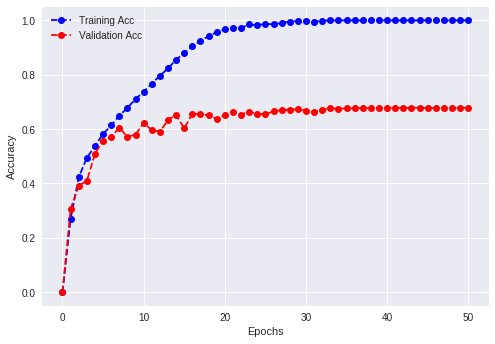

In [11]:

history = train(network)

## Network 2.
* same as network 1 but the dense layer has 1024 neurons

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

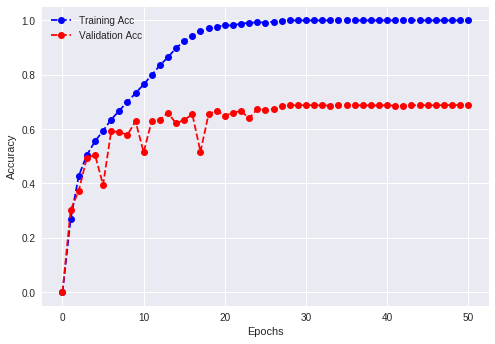

In [12]:
network = models.Sequential()
network.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(1024, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))
network.summary()
network.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
h = train(network)

## Network 3.
* same as network 2 but "half as much neurons" in all layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
__________

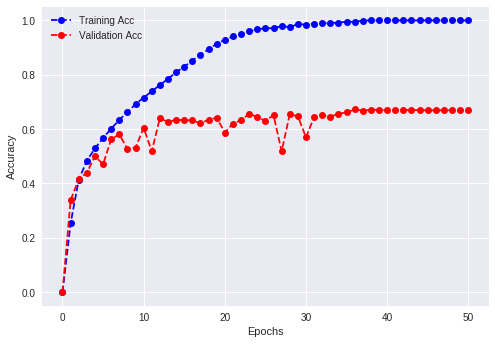

In [14]:
network = models.Sequential()
network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
network.add(layers.Conv2D(32, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(n_classes, activation='softmax'))
network.summary()
network.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
h = train(network)